In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from open_atmos_jupyter_utils import show_plot
from PyMPDATA import Options, Solver, Stepper, VectorField, ScalarField
from PyMPDATA.boundary_conditions import Constant

In [2]:
def f(x0, t, xi):
    return x0 - np.sin(np.pi*x0)*t - xi

def df(x0, t, _):
    return 1 - np.cos(np.pi*x0)*np.pi*t

In [3]:
x = np.linspace(-1, 1, 200)
t_range = [0, 0.1, 0.3, 0.5, 0.7, 1]
tshock = 1 / np.pi

In [4]:
def find_root(x0, t, xi):
    return root_scalar(f, args=(t, xi), x0=x0, method='newton', maxiter=200, fprime=df).root

In [5]:
def anal_solution(x, t):
    u = np.zeros(len(x))
    for i, xi in enumerate(x):
        if t < tshock:
            x0 = find_root(x0=0, t=t, xi=xi)
            u[i] = -np.sin(np.pi * x0)
        else:
            if xi == 0:
                u[i] = 0
            else:
                x0 = find_root(x0=xi/abs(xi), t=t, xi=xi)
                u[i] = -np.sin(np.pi * x0)
    return u

In [6]:
solutions = np.zeros((len(x), len(t_range)))
for j, t in enumerate(t_range):
    solutions[:, j] = anal_solution(x, t)

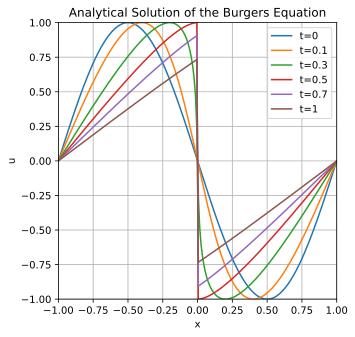

In [7]:
fig = plt.figure(figsize=(5, 5))
plt.plot(x, solutions)
plt.xlabel('x')
plt.ylabel('u')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('Analytical Solution of the Burgers Equation')
plt.legend([f't={t}' for t in t_range])
plt.grid(True)
show_plot(fig=fig, filename='analytical')

In [8]:
options = Options(nonoscillatory=True, infinite_gauge=True)

In [9]:
t_max = 0.1
nt = 40
nx = 1000
dt = t_max / nt

courants_x = np.linspace(-1, 1, nx + 1, endpoint=False)
dx = courants_x[1] - courants_x[0]
x = courants_x[:-1] + dx / 2

u0 = -np.sin(np.pi * x)
courants = -np.sin(np.pi * courants_x) * dt / dx

In [10]:
stepper = Stepper(options=options, n_dims=1)
advectee = ScalarField(data=u0, 
                       halo=options.n_halo, 
                       boundary_conditions=(Constant(0),Constant(0)))
advector = VectorField(data=(courants,),
                       halo=options.n_halo, 
                       boundary_conditions=(Constant(0),Constant(0))) 

solver = Solver(stepper=stepper, advectee=advectee, advector=advector)

In [11]:
for _ in range(nt):
    vel = advectee.get()
    advector.get_component(0)[1:-1] = (np.diff(vel) / 2 + vel[:-1]) * dt / dx
    solver.advance(n_steps=1)
state = solver.advectee.get()

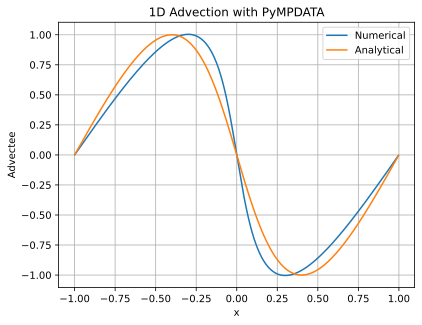

In [12]:
plt.plot(x, state, label='Numerical')
plt.plot(x, anal_solution(x, t_max), label='Analytical')
plt.xlabel("x")
plt.ylabel("Advectee")
plt.title("1D Advection with PyMPDATA")
plt.grid(True)
plt.legend()
plt.show()